Differential condensability analysis and plots

In [1]:
# python modules
import sys
import copy
import re
import random
import pickle
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import scipy
from scipy import stats

In [2]:
# custom modules
sys.path.append('/Users/sangwoopark/Projects/condense-seq/postpro_scripts')
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [25]:
def plot_score_scatter (ID_score1,
                        ID_score2,
                        ID_color,
                        IDs=None,
                        standardize_color=True,
                        ID_text={},
                        fig_width=None,
                        fig_height=None,
                        vmin=-5,
                        vmax=5,
                        alpha=0.3,
                        size=2,
                        xlim=[None,None],
                        ylim=[None,None],
                        xlabel='',
                        ylabel='',
                        title=None,
                        cbar_ylabel='',
                        show=True,
                        save_path='./',
                        save=False,
                        note=''):

    # custom diverging colormap with white background
    pastel_jet = LinearSegmentedColormap.from_list('white_viridis',
                                                   [(0, 'darkblue'),
                                                    (0.1, 'blue'),
                                                    (0.2, 'tab:blue'),
                                                    (0.4, 'tab:cyan'),
                                                    (0.5, 'ivory'),
                                                    (0.6, 'tab:orange'),
                                                    (0.8, 'tab:red'),
                                                    (0.9, 'red'),
                                                    (1, 'darkred')
                                                    ], N=256)

    all_IDs = set(ID_score1.keys()) & set(ID_score2.keys())

    if IDs == None:
        IDs = all_IDs
    else:
        IDs = all_IDs & set(IDs)

    out_IDs = IDs & set(ID_text.keys())
    IDs -= out_IDs

    IDs = sorted(list(IDs))
    out_IDs = sorted(list(out_IDs))
    
    X, Y = [], []
    C = []
    for ID in IDs:
        X.append(ID_score1[ID])
        Y.append(ID_score2[ID])
        C.append(ID_color[ID])

    if standardize_color:
        C = stats.zscore(C)

    # draw all genes
    if fig_width==None or fig_height==None:
        fig = plt.figure()
    else:
        fig = plt.figure(figsize=(fig_width,
                                  fig_height))
    
    plt.scatter(X,
                Y,
                c=C,
                cmap=pastel_jet,
                vmin=vmin,
                vmax=vmax,
                alpha=alpha,
                s=size)

    for ID in out_IDs:
        text = ID_text[ID]
        x, y = ID_score1[ID], ID_score2[ID]
        
        plt.plot(x,
                 y,
                 'kx',
                 markersize=6,
                 alpha=1,
                 zorder=10,
                 mew=2)
        
        plt.annotate(text,
                     (x+0.05, y+0.05),
                     color='black',
                     zorder=40,
                     size=10,
                     weight='bold')

    plt.plot(xlim,
             ylim,
             'k--',
             alpha=0.7)
    
    plt.xlim(xlim)
    plt.ylim(ylim)

    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)

    if title!=None:
        plt.title(title, fontsize=15)

    cbar = plt.colorbar()
    cbar.ax.set_ylabel(cbar_ylabel,
                       rotation=-90,
                       va="bottom")

    if save:
        #plt.savefig(save_path + "score_scatter_%s.png" % (note),
        #            bbox_inches='tight',
        #            dpi=300)
        plt.savefig(save_path + "score_scatter_%s.svg" % (note),
                    bbox_inches='tight')
    if show:
        plt.tight_layout()
        plt.show()
    plt.close()


In [6]:
### set target chromosome
chr_choices = cell_chrnames['H1']

In [7]:
### read GTF file
GTF_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/GTF/'
GTF_fname = 'ENCFF159KBI.gtf'
geneID_field_value = load_file.read_GTF (GTF_path + GTF_fname,
                                         chr_list=chr_choices)

In [8]:
### get near TSS interval for each genes
chr_geneID_interval = {}
for geneID in geneID_field_value:
    try:
        chr = geneID_field_value[geneID]['chr']
        pos = geneID_field_value[geneID]['TSS']
    except:
        continue
    interval = (pos-2500, pos+2500)

    if chr not in chr_geneID_interval:
        chr_geneID_interval[chr] = {}
    chr_geneID_interval[chr][geneID] = interval

In [9]:
### set target gtab file
gtab_path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'

dinfo_dkey = {'H1_NCP_sp_1rep_deep_chr(\d+|[XY])_score.gtab.gz':
              {'H1_NCP_sp_8_1rep_deep': (1, 'H1', 'score', 8)},
              'GM_NCP_sp_1rep_deep_chr(\d+|[XY])_score.gtab.gz':
              {'GM_NCP_sp_8_1rep_deep': (1, 'GM', 'score', 8)}}

In [10]:
### load condense-seq data and get mean score near TSS of genes
dkey_geneID_mscore = {}
for fkey in dinfo_dkey:
    field_dkey = dinfo_dkey[fkey]

    if not field_dkey:
        field_choices = None
    else:
        field_choices = field_dkey.keys()

    for fname in glob.glob(gtab_path + '*'):
        if not re.match(fkey, fname.rsplit('/')[-1]):
            continue

        print "loading %s" % (fname.rsplit('/')[-1])

        field_chr_ID_value = load_file.read_gtab(fname,
                                                 mode='col',
                                                 field_choices=field_choices,
                                                 chr_choices=chr_choices,
                                                 skip_nan=True,
                                                 by_chr=True)

        for field, chr_ID_value in field_chr_ID_value.items():
            try:
                dkey = field_dkey[field]
            except:
                dkey = field

            for chr, ID_value in chr_ID_value.items():
                ID_loc = {}
                for ID in ID_value:
                    if len(ID) == 2:
                        ID_loc[ID] = ID[1]
                    else:
                        ID_loc[ID] = ID[1:]
                
                geneID_interval = chr_geneID_interval[chr]

                geneID_mscore = statis.bin_data_mean(geneID_interval,
                                                     ID_loc,
                                                     ID_value,
                                                     min_sample_size=10,
                                                     skip_nan=True,
                                                     silent=True)

                if dkey not in dkey_geneID_mscore:
                    dkey_geneID_mscore[dkey] = {}
                dkey_geneID_mscore[dkey].update(geneID_mscore)


loading GM_NCP_sp_1rep_deep_chr10_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr11_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr12_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr13_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr14_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr15_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr16_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr17_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr18_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr19_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr1_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr20_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr21_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr22_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr2_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr3_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr4_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr5_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr6_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr7_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr8_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chr9_score.gtab.gz


loading GM_NCP_sp_1rep_deep_chrX_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr10_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr11_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr12_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr13_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr14_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr15_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr16_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr17_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr18_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr19_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr1_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr20_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr21_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr22_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr2_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr3_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr4_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr5_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr6_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr7_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr8_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chr9_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chrX_score.gtab.gz


loading H1_NCP_sp_1rep_deep_chrY_score.gtab.gz


In [11]:
#### setting data to load (file-extension, dtype, resolution, rep, cell, sample, agent, tnum)
#gtab_path = "/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/"
#dkey_list = [('score.gtab.gz', 'score', 'single', 1, 'H1', 'NCP', 'sp', 8),
#             ('score.gtab.gz', 'score', 'single', 1, 'GM', 'NCP', 'sp', 8)]

In [12]:
#### load condense-seq data and get mean score near TSS of genes
#dkey_geneID_mscore = {}
#for dkey in dkey_list:
#    print dkey
#    exten, dtype, resol, rep, cell, sample, agent, tnum = dkey
#
#    chr_list = cell_chrnames[cell]
#
#    geneID_mscore = {}
#    for chr in chr_list:
#        print '\t %s' % (chr)
#        
#        gtab_fname = '_'.join([cell,
#                               sample,
#                               agent,
#                               str(rep) + 'rep',
#                               'deep',
#                               chr]) + '_' + exten
#
#        field = '_'.join([cell,
#                          sample,
#                          agent,
#                          str(tnum),
#                          str(rep) + 'rep',
#                          'deep'])
#        
#        ID_score = load_file.read_gtab (gtab_path + gtab_fname,
#                                        mode='col',
#                                        field_choices=[field])[field]
#        ID_win = {ID:ID[1] for ID in ID_score}
#        geneID_interval = chr_geneID_interval[chr]
#
#        geneID_mscore.update(statis.bin_data_mean(geneID_interval,
#                                                  ID_win,
#                                                  ID_score,
#                                                  max_pos=max(ID_win.values()),
#                                                  min_sample_size=10,
#                                                  skip_nan=True,
#                                                  silent=True))
#
#    dkey_geneID_mscore[dkey] = geneID_mscore
    

In [13]:
#### save the data as pickle
#fname = 'human_geneID_mscore'
#pickle.dump(dkey_geneID_mscore, open(fname + ".pickle", "wb"))

In [14]:
### read RNA-seq data
RNAseq_path = '/Users/sangwoopark/jhu_rockfish/HumanEpigeneticData/RNAseq/'
cell_RNAseq_fname = {'H1':'ENCFF174OMR.tsv',
                     'GM':'ENCFF345SHY.tsv'}
dkey_geneID_FPKM = {}
for dkey in dkey_geneID_mscore:
    cell = dkey[1]
    #exten, dtype, resol, rep, cell, sample, agent, tnum = dkey
    RNAseq_fname = cell_RNAseq_fname[cell]
    geneID_FPKM = load_file.read_ENCODE_RNA_seq(RNAseq_path + RNAseq_fname)
    dkey_geneID_FPKM[dkey] = geneID_FPKM

In [15]:
### define common geneIDs
target_geneIDs = set([])
dkeys = dkey_geneID_mscore.keys()
for i in range(len(dkeys)):
    dkey = dkeys[i]
    geneID_mscore = dkey_geneID_mscore[dkey]
    geneIDs = set(geneID_mscore.keys())
    if i == 0:
        target_geneIDs |= geneIDs
        continue
    target_geneIDs &= geneIDs
target_geneIDs = sorted(list(target_geneIDs))
print 'Total gene count:' + str(len(target_geneIDs))

Total gene count:58055


In [16]:
### standardize the condensability scores
dkey_geneID_zscore = {}
for dkey in dkeys:
    geneID_mscore = dkey_geneID_mscore[dkey]
    geneID_zscore = statis.standardize_dict(geneID_mscore,
                                            keys=target_geneIDs)
    dkey_geneID_zscore[dkey] = geneID_zscore    

In [17]:
### get gene expression differences
dkey1 = (1, 'H1', 'score', 8)
dkey2 = (1, 'GM', 'score', 8)
geneID_dlogFPKM = {}
for geneID in target_geneIDs:
    try:
        FPKM1 = dkey_geneID_FPKM[dkey1][geneID]
        FPKM2 = dkey_geneID_FPKM[dkey2][geneID]
    except:
        continue
    dlogFPKM = np.log2(1+FPKM2) - np.log2(1+FPKM1)
    geneID_dlogFPKM[geneID] = dlogFPKM


In [18]:
### set stem cell marker genes
ESC_tf_cores =  ['Pou5f1', 'Sox2', 'KLF4', 'Nanog']
ESC_tf_others = ['Zfp42', 'UTF1', 'ZFX', 'TBN', 'FoxD3', 'HMGA2', 'NAC1', 'NR6A1', 'Stat3', 'LEF1', 'TCF3', 'Sall4', 'Fbxo15', 'L1TD1', 'Gdf3', 'Dppa5', 'Dppa4', 'Dppa2', 'Dppa3']
ESC_tf_cores = [gname.upper() for gname in ESC_tf_cores]
ESC_tf_others = [gname.upper() for gname in ESC_tf_others]
ESC_gnames = ESC_tf_cores + ESC_tf_others

In [27]:
### find Ensemble Gene ID for stem cell marker genes
ESC_gname_geneIDs = {gname :[] for gname in ESC_gnames}
for geneID in target_geneIDs:
    gname = geneID_field_value[geneID]['geneName'].upper()
    try:
        ESC_gname_geneIDs[gname].append(geneID)
    except:
        continue

ESC_geneID_gname = {}
for gname in ESC_gname_geneIDs:
    if len(ESC_gname_geneIDs[gname]) == 1:
        geneID = ESC_gname_geneIDs[gname][0]
        assert geneID not in ESC_geneID_gname
        ESC_geneID_gname[geneID] = gname

geneID_text = {}
for geneID in ESC_geneID_gname:
    gname = ESC_geneID_gname[geneID]
    if gname in ESC_tf_cores:
        text = gname
    else:
        text = ''
        #text = gname
    geneID_text[geneID] = text


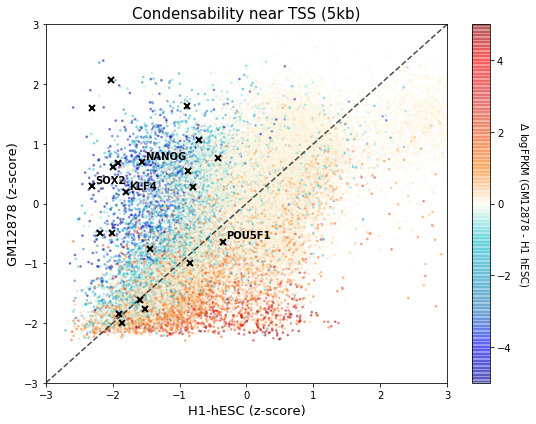

In [28]:
### plot condensability with gene expression differences
geneID_zscore1 = dkey_geneID_zscore[dkey1]
geneID_zscore2 = dkey_geneID_zscore[dkey2]

plot_score_scatter (geneID_zscore1,
                    geneID_zscore2,
                    geneID_dlogFPKM,
                    IDs=target_geneIDs,
                    standardize_color=True,
                    ID_text=geneID_text,
                    fig_width=7.8,
                    fig_height=6,
                    vmin=-5,
                    vmax=5,
                    alpha=0.4,
                    size=3,
                    xlim=[-3,3],
                    ylim=[-3,3],
                    xlabel='H1-hESC (z-score)',
                    ylabel='GM12878 (z-score)',
                    title='Condensability near TSS (5kb)',
                    cbar_ylabel='$\\Delta$ logFPKM (GM12878 - H1 hESC)',
                    save_path='./data/',
                    save=True,
                    note='H1vsGM')
